In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'customer-purchasing-behaviors:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5628931%2F9297050%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240909%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240909T043316Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D137f2cba9b0a8d791c8333df4a8853e7e75e051c9eb7dc9c05555132b2ec2310bffa12e2a3dc314a7830582a4ed278fb20d12f96a146f946fb63f0ab0bdba2fd0bdbc650388726cfccd6e400d42c3e65744764e811942489946bf99c787c162541ab693a8ee1b37d5f3276ab3375ada1705d56ccc7ef9027c718f3c7671776c06bc495a066d17d4e9138e4d5e9b4686a58b2d8e2e4a56a565e80c2b3d620e7f8e70a96b1d82d05f159162402b4e8f89859c401901a5ae7bdb15831234ad32afbf236c2a49447bb0049cfec57d673c6911eb70651132ca73fc717cf3e0b857c03f538008bb12b2fa98e63e0883c88a57e0ce31ac4a58db36895d8465d868f6235'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('dark')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Importing dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-purchasing-behaviors/Customer Purchasing Behaviors.csv


In [ ]:
# Load the data
data = pd.read_csv("/kaggle/input/customer-purchasing-behaviors/Customer Purchasing Behaviors.csv")
data.head()

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,1,25,45000,200,4.5,North,12
1,2,34,55000,350,7.0,South,18
2,3,45,65000,500,8.0,West,22
3,4,22,30000,150,3.0,East,10
4,5,29,47000,220,4.8,North,13


# Fields and Data Types 📊:
The dataset includes the following attributes:

- **customer_id:** Unique ID of the customer.
- **age:** The age of the customer.
- **annual_income:** The customer's annual income (in USD).
- **purchase_amount:** The total amount of purchases made by the customer (in USD).
- **purchase_frequency:** Frequency of customer purchases (number of times per year).
- **region:** The region where the customer lives (North, South, East, West).
- **loyalty_score:** Customer's loyalty score (a value between 0-100).

In [ ]:
# Display information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             238 non-null    int64  
 1   age                 238 non-null    int64  
 2   annual_income       238 non-null    int64  
 3   purchase_amount     238 non-null    int64  
 4   loyalty_score       238 non-null    float64
 5   region              238 non-null    object 
 6   purchase_frequency  238 non-null    int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 13.1+ KB
None


In [ ]:
# Descriptive statistics
data.describe()

,user_id,age,annual_income,purchase_amount,loyalty_score,purchase_frequency
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,119.500000,38.676471,57407.563025,425.630252,6.794118,19.798319
std,68.848868,9.351118,11403.875717,140.052062,1.899047,4.562884
min,1.000000,22.000000,30000.000000,150.000000,3.000000,10.000000
25%,60.250000,31.000000,50000.000000,320.000000,5.500000,17.000000
50%,119.500000,39.000000,59000.000000,440.000000,7.000000,20.000000
75%,178.750000,46.750000,66750.000000,527.500000,8.275000,23.000000
max,238.000000,55.000000,75000.000000,640.000000,9.500000,28.000000


In [ ]:
# Display column names
data.columns

Index(['user_id', 'age', 'annual_income', 'purchase_amount', 'loyalty_score',
       'region', 'purchase_frequency'],
      dtype='object')

# Handling missing data

In [ ]:
# Verify the data
print(data.isnull().sum())

user_id               0
age                   0
annual_income         0
purchase_amount       0
loyalty_score         0
region                0
purchase_frequency    0
dtype: int64


# EDA (Exploratory Data Analysis)

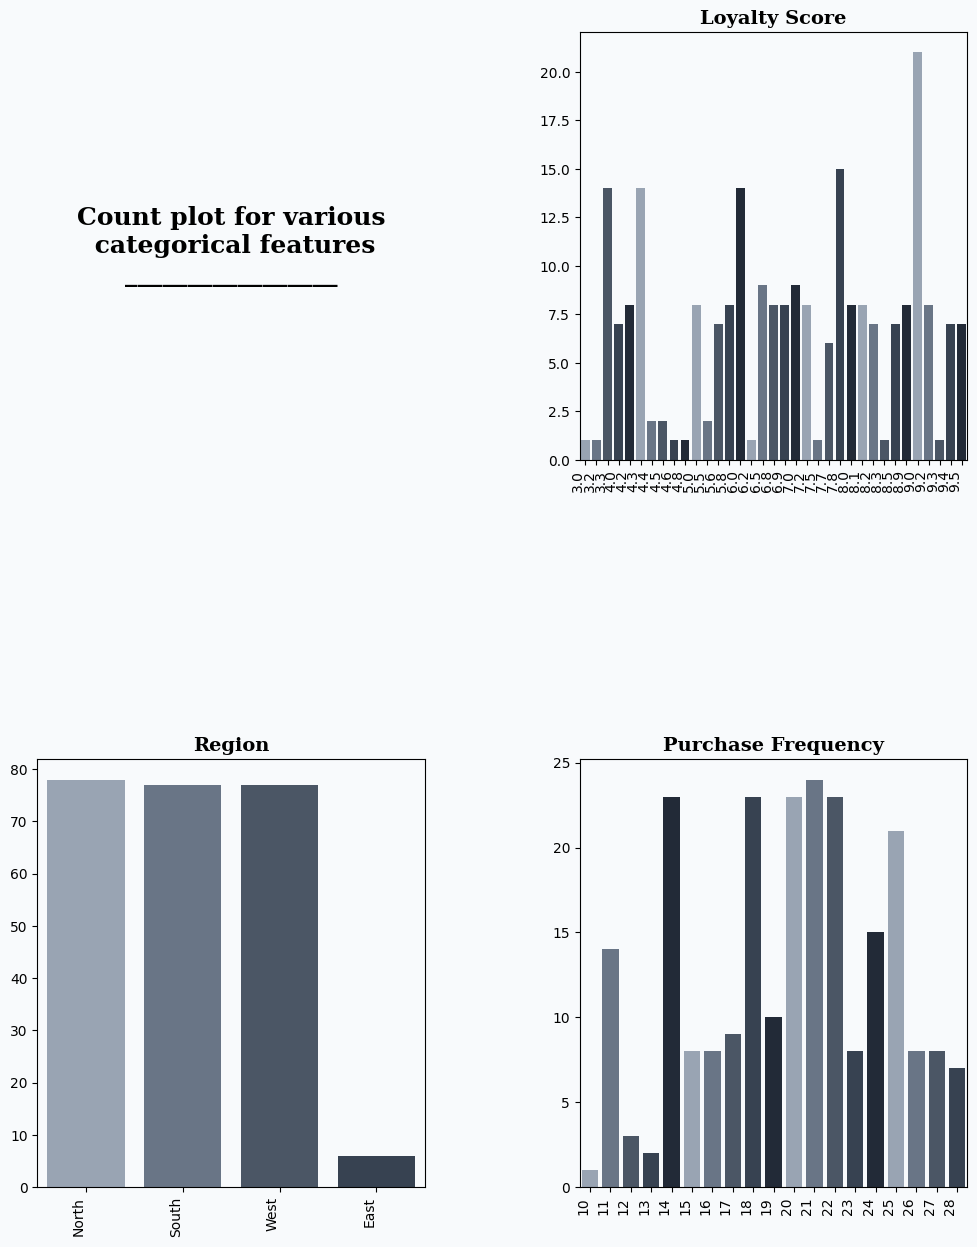

In [ ]:
# Figure adjustments

# Larger size for better visualization
fig = plt.figure(figsize=(12, 15))
gs = fig.add_gridspec(2, 2)
# Increases space between subplots
gs.update(wspace=0.4, hspace=0.7)


background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]
fig.patch.set_facecolor(background_color)
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(2)]
for ax in axes:
    ax.set_facecolor(background_color)

# Title of the plot
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Count plot for various\n categorical features\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

# Plot for each categorical feature
plot_features = ['loyalty_score', 'region', 'purchase_frequency']
titles = ["Loyalty Score", "Region", "Purchase Frequency"]

for i, feature in enumerate(plot_features):
    ax = axes[i + 1]
    ax.set_title(titles[i], loc='center', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
    sns.countplot(ax=ax, data=data, x=feature, palette=color_palette)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=10)

# Adjust and show
plt.show()

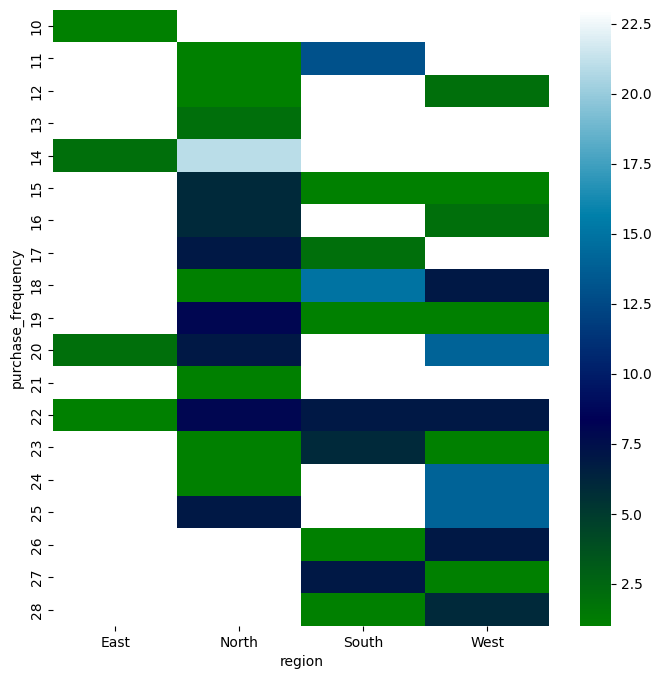

In [ ]:
# Region vs Purchase Frequency
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['purchase_frequency'].value_counts()
    for x_label, grp in data.groupby('region')
})
sns.heatmap(df_2dhist, cmap='ocean')
plt.xlabel('region')
_ = plt.ylabel('purchase_frequency')

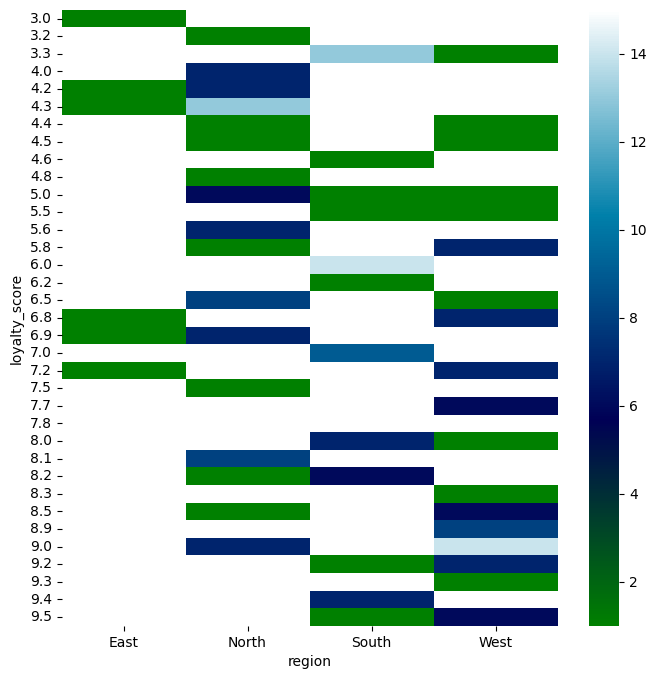

In [ ]:
# Region vs Loyalty Score
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['loyalty_score'].value_counts()
    for x_label, grp in data.groupby('region')
})
sns.heatmap(df_2dhist, cmap='ocean')
plt.xlabel('region')
_ = plt.ylabel('loyalty_score')

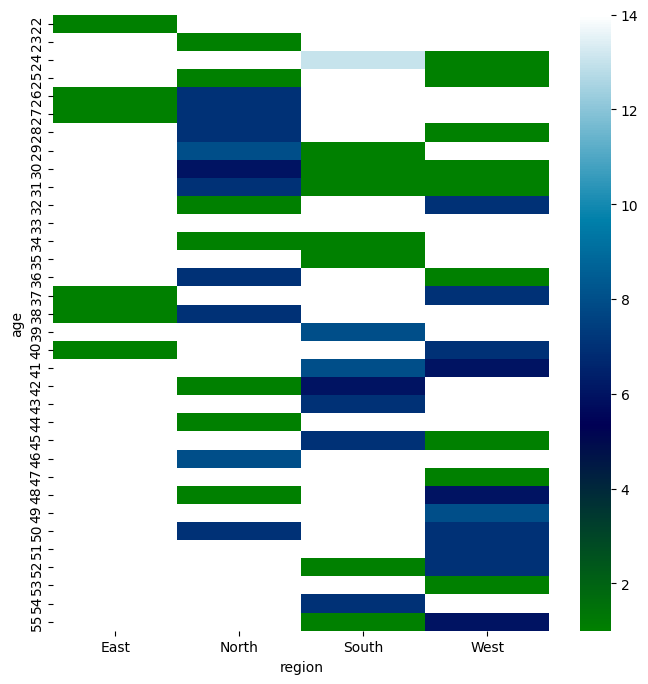

In [ ]:
# Region vs Age
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['age'].value_counts()
    for x_label, grp in data.groupby('region')
})
sns.heatmap(df_2dhist, cmap='ocean')
plt.xlabel('region')
_ = plt.ylabel('age')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

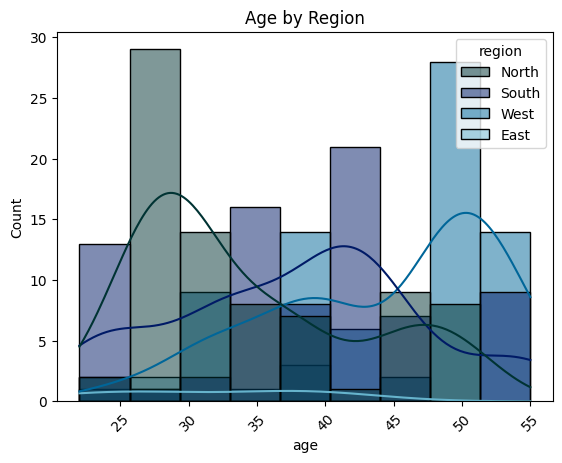

In [ ]:
# Age by Region
plt.xticks(rotation=45)
sns.histplot(data=data, x='age', hue="region",palette="ocean", kde=True)
plt.title('Age by Region')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

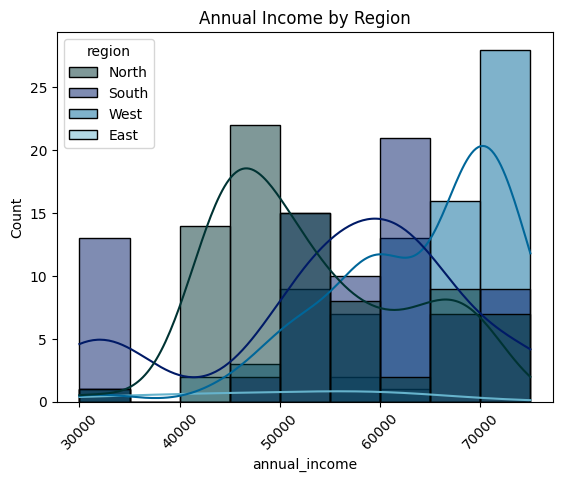

In [ ]:
# Annual Income by Region
plt.xticks(rotation=45)
sns.histplot(data=data, x='annual_income', hue="region",palette="ocean", kde=True)
plt.title('Annual Income by Region')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

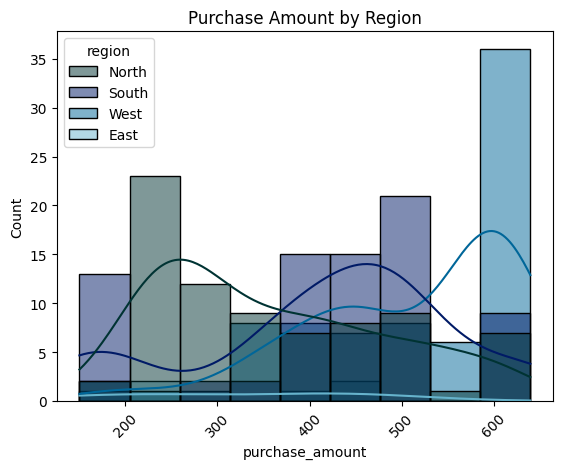

In [ ]:
# Purchase Amount by Region
plt.xticks(rotation=45)
sns.histplot(data=data, x='purchase_amount', hue="region",palette="ocean", kde=True)
plt.title('Purchase Amount by Region')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

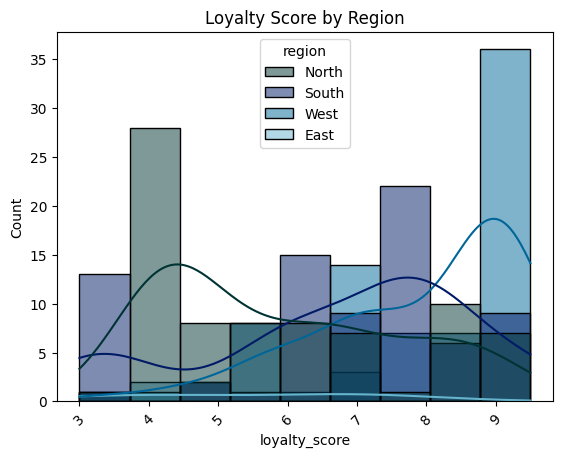

In [ ]:
# Loyalty Score by Region
plt.xticks(rotation=45)
sns.histplot(data=data, x='loyalty_score', hue="region",palette="ocean", kde=True)
plt.title('Loyalty Score by Region')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

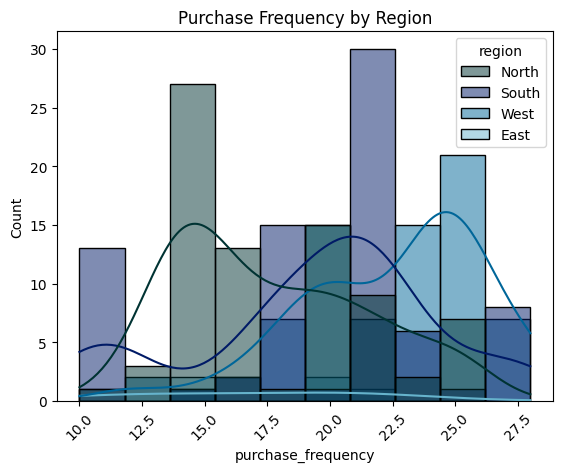

In [ ]:
# Purchase Frequency by Region
plt.xticks(rotation=45)
sns.histplot(data=data, x='purchase_frequency', hue="region",palette="ocean", kde=True)
plt.title('Purchase Frequency by Region')
plt.show()

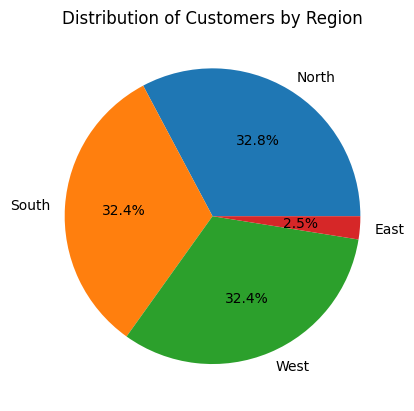

In [ ]:
# Count the occurrences of each region
region_counts = data['region'].value_counts()

# Create the pie chart
plt.pie(region_counts.values, labels=region_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Customers by Region')
plt.show()

                     user_id       age  annual_income  purchase_amount  \
user_id             1.000000  0.067061       0.059031         0.080621   
age                 0.067061  1.000000       0.974833         0.986140   
annual_income       0.059031  0.974833       1.000000         0.984208   
purchase_amount     0.080621  0.986140       0.984208         1.000000   
loyalty_score       0.060819  0.981835       0.984351         0.994147   
purchase_frequency  0.070541  0.980532       0.982920         0.993579   

                    loyalty_score  purchase_frequency  
user_id                  0.060819            0.070541  
age                      0.981835            0.980532  
annual_income            0.984351            0.982920  
purchase_amount          0.994147            0.993579  
loyalty_score            1.000000            0.986990  
purchase_frequency       0.986990            1.000000  


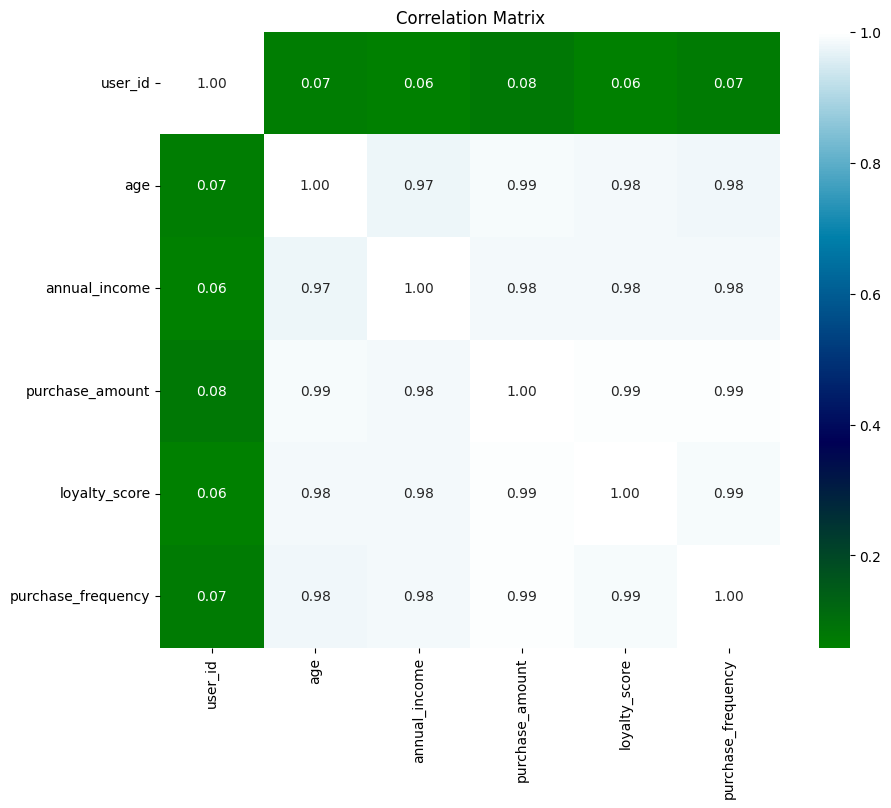

In [ ]:
# Calculate the correlation matrix for numerical columns only
correlation_matrix = data.select_dtypes(include=['number']).corr()

# Display the correlation matrix
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='ocean', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

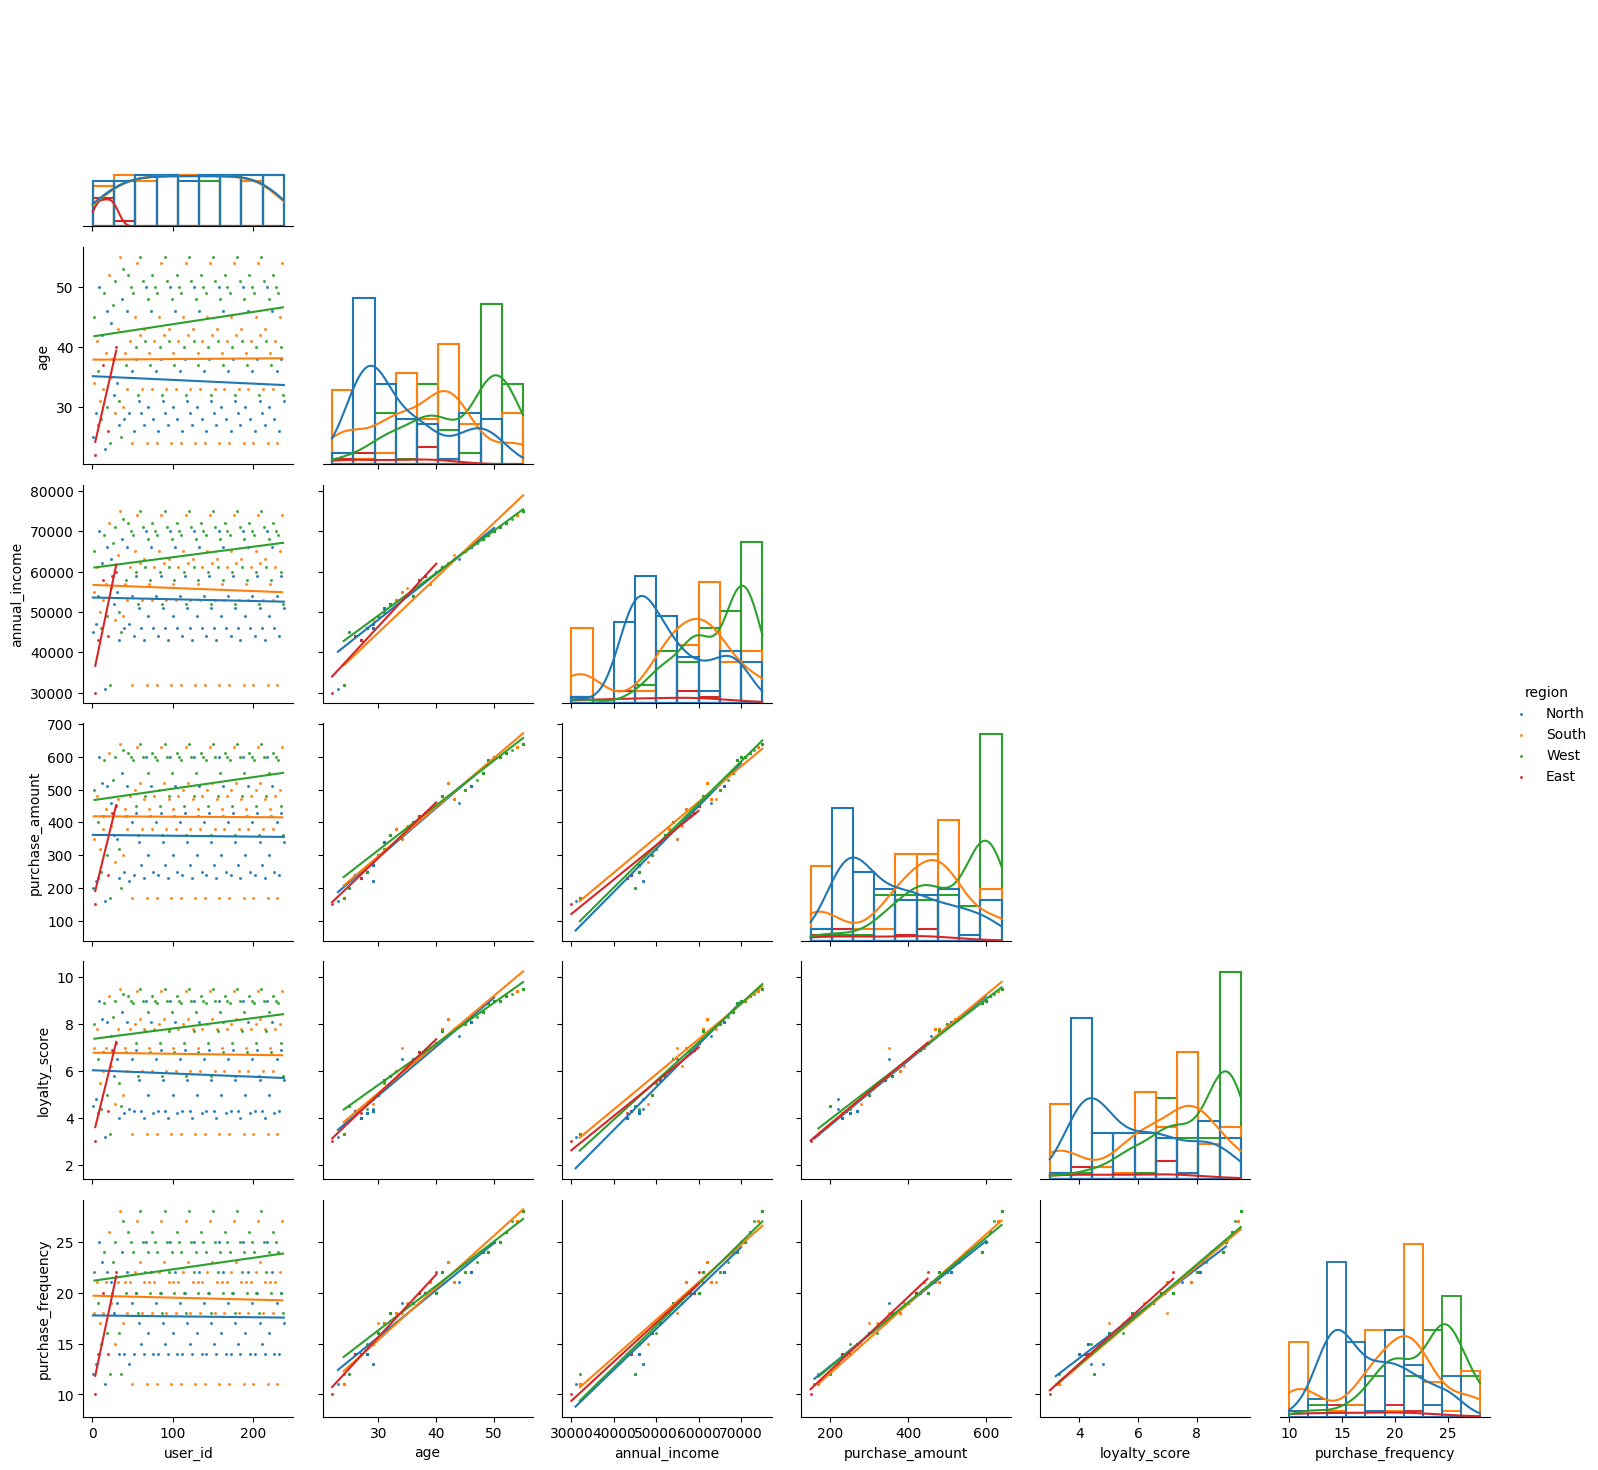

In [ ]:
g = sns.PairGrid(data, hue = 'region', vars = data.select_dtypes(include = ['int', 'float']), corner = True)
g.map_lower(sns.regplot, ci = False, line_kws={'lw': 1.5}, scatter_kws={'s': 1.5})
g.map_diag(sns.histplot, kde = True, fill = False)
g.add_legend()
g.fig.show()

In [ ]:
def encode_to_binary(data):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Iterate through each column in the DataFrame
    for col in data.columns:
        # Check if the column is categorical
        if data[col].dtype == 'object':
            # Encode categorical values to binary (0 and 1)
            data[col] = label_encoder.fit_transform(data[col])

    return data

# Encode categorical variables to binary (0 and 1)
data = encode_to_binary(data)
data.head()

,user_id,age,annual_income,purchase_amount,loyalty_score,region,purchase_frequency
0,1,25,45000,200,4.5,1,12
1,2,34,55000,350,7.0,2,18
2,3,45,65000,500,8.0,3,22
3,4,22,30000,150,3.0,0,10
4,5,29,47000,220,4.8,1,13


# Data Preprocessing

In [ ]:
# Split features and target variable
X = data.drop('loyalty_score', axis=1)  # Features (independent variables)
y = data['loyalty_score']  # Target variable (dependent variable)

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (190, 6)
y_train shape: (190,)
X_test shape: (48, 6)
y_test shape: (48,)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'SVC': SVR(),
    'Linear Regression': LinearRegression()
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Check if the model is a regressor
    if name in ['Decision Tree', 'Random Forest', 'KNN', 'SVC', 'Linear Regression']:
        # Calculate Mean Squared Error (MSE) for regression models
        mse = mean_squared_error(y_test, y_pred)
        print(f'Model: {name}')
        print(f'Mean Squared Error: {mse:.5f}')
        print()

Model: Decision Tree
Mean Squared Error: 0.01125

Model: Random Forest
Mean Squared Error: 0.00127

Model: KNN
Mean Squared Error: 0.00277

Model: SVC
Mean Squared Error: 0.06847

Model: Linear Regression
Mean Squared Error: 0.03506



=== Statistical Summary of Numerical Variables ===
          user_id         age  annual_income  purchase_amount  loyalty_score  \
count  238.000000  238.000000     238.000000       238.000000     238.000000   
mean   119.500000   38.676471   57407.563025       425.630252       6.794118   
std     68.848868    9.351118   11403.875717       140.052062       1.899047   
min      1.000000   22.000000   30000.000000       150.000000       3.000000   
25%     60.250000   31.000000   50000.000000       320.000000       5.500000   
50%    119.500000   39.000000   59000.000000       440.000000       7.000000   
75%    178.750000   46.750000   66750.000000       527.500000       8.275000   
max    238.000000   55.000000   75000.000000       640.000000       9.500000   

           region  purchase_frequency  
count  238.000000          238.000000  
mean     1.945378           19.798319  
std      0.867340            4.562884  
min      0.000000           10.000000  
25%      1.000000           

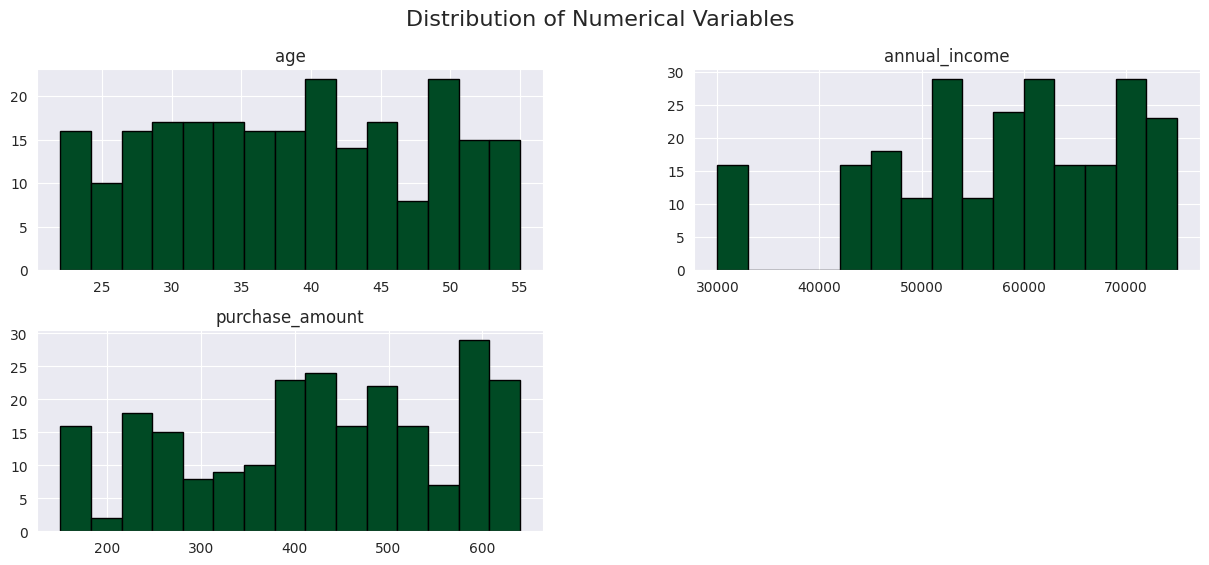

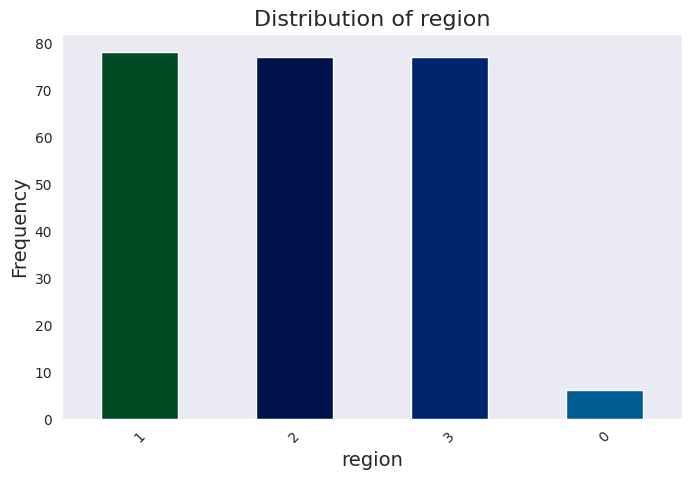

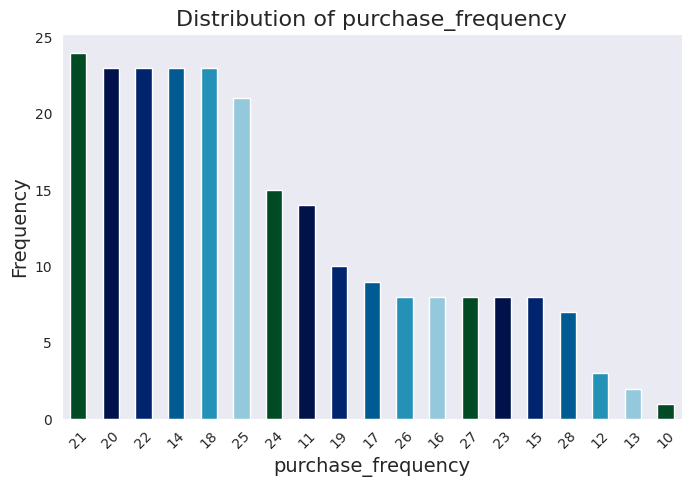

============== Correlation Analysis ==============
                     user_id       age  annual_income  purchase_amount  \
user_id             1.000000  0.067061       0.059031         0.080621   
age                 0.067061  1.000000       0.974833         0.986140   
annual_income       0.059031  0.974833       1.000000         0.984208   
purchase_amount     0.080621  0.986140       0.984208         1.000000   
loyalty_score       0.060819  0.981835       0.984351         0.994147   
region              0.089772  0.443132       0.409226         0.452714   
purchase_frequency  0.070541  0.980532       0.982920         0.993579   

                    loyalty_score    region  purchase_frequency  
user_id                  0.060819  0.089772            0.070541  
age                      0.981835  0.443132            0.980532  
annual_income            0.984351  0.409226            0.982920  
purchase_amount          0.994147  0.452714            0.993579  
loyalty_score            1

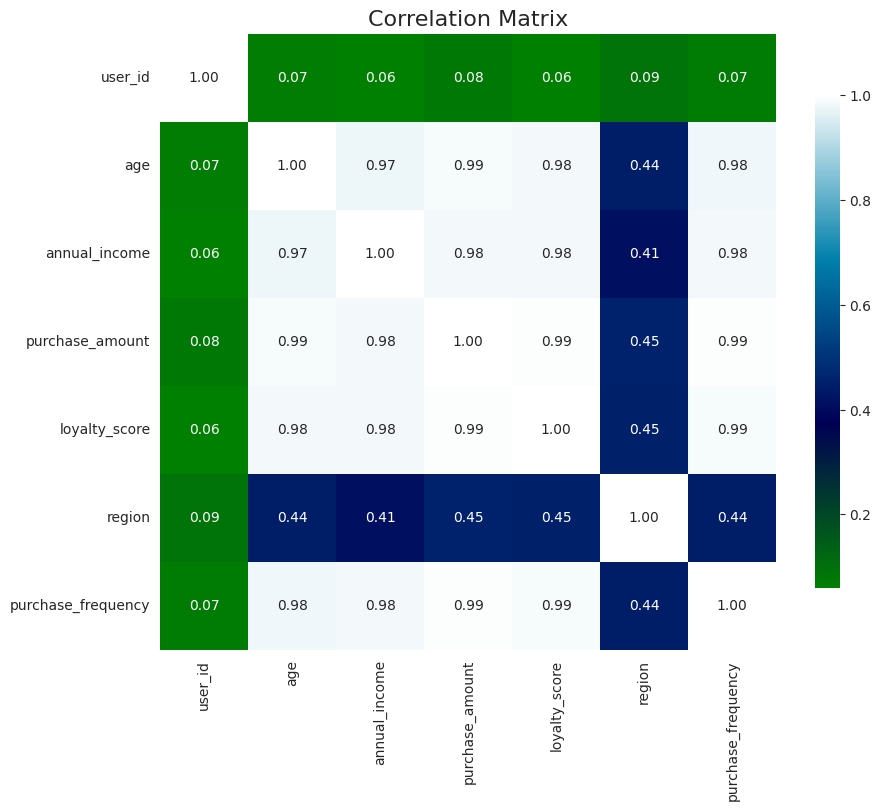

================ Outlier Analysis ================


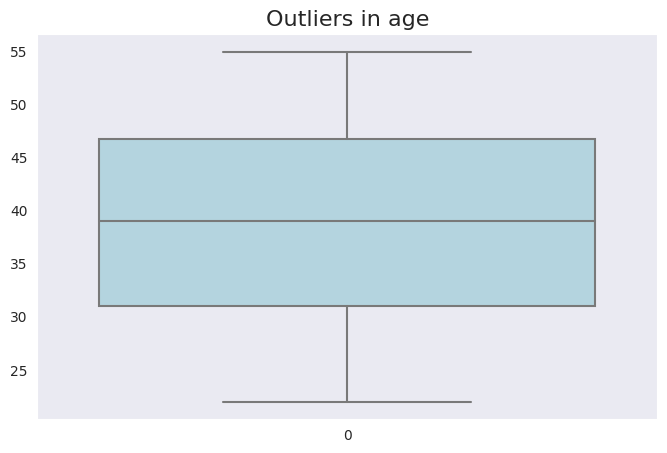

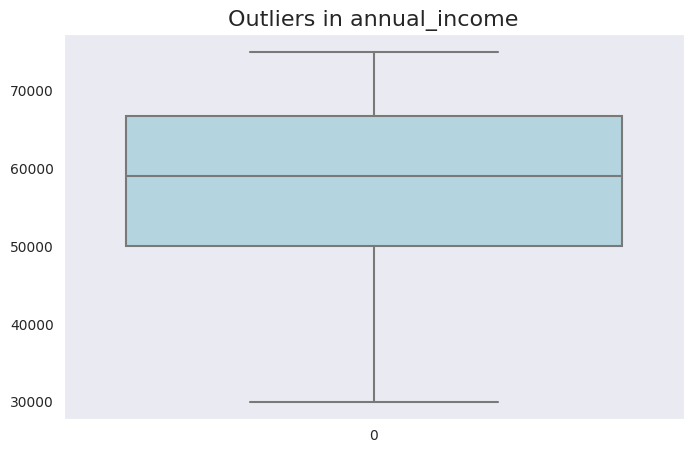

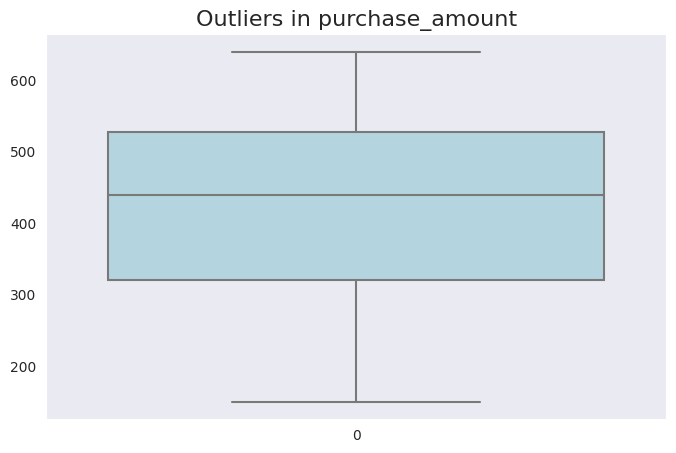

Linear Regression Performance:
Mean Squared Error (MSE): 0.0351
R^2 Score: 0.9915
------------------------------
Decision Tree Regressor Performance:
Mean Squared Error (MSE): 0.0087
R^2 Score: 0.9979
------------------------------
Random Forest Regressor Performance:
Mean Squared Error (MSE): 0.0009
R^2 Score: 0.9998
------------------------------
KNN Regressor Performance:
Mean Squared Error (MSE): 0.0028
R^2 Score: 0.9993
------------------------------
Support Vector Regressor Performance:
Mean Squared Error (MSE): 0.0685
R^2 Score: 0.9834
------------------------------


In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Set the color palette for visualizations
sns.set_palette("ocean")

# Load the data (Asegúrate de tener la ruta correcta)
# data = pd.read_csv('path_to_your_data.csv')

# Generate a statistical summary of numerical variables
def generate_statistical_summary(data):
    print(" Statistical Summary of Numerical Variables ".center(50, "="))
    print(data.describe())
    print("\n")

# Handling missing data
def missing_data_analysis(data):
    print(" Missing Data Analysis ".center(50, "="))
    missing_data = data.isnull().sum()
    print(missing_data[missing_data > 0])
    print("\n")

# Distribution of categorical variables
def categorical_distribution(data, categorical_cols):
    print(" Distribution of Categorical Variables ".center(50, "="))
    for col in categorical_cols:
        print(f"Distribution of {col}:")
        print(data[col].value_counts())
        print("\n")

# Distribution graphs for numerical variables
def plot_numerical_distributions(data, numerical_cols):
    data[numerical_cols].hist(bins=15, figsize=(15, 6), edgecolor='black')
    plt.suptitle('Distribution of Numerical Variables', fontsize=16)
    plt.show()

# Bar graphs for categorical variables
def plot_categorical_bars(data, categorical_cols):
    for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        data[col].value_counts().plot(kind='bar', color=sns.color_palette("ocean"))
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(rotation=45)
        plt.show()

# Correlation analysis between numerical variables
def correlation_analysis(numeric_df):
    print(" Correlation Analysis ".center(50, "="))
    corr = numeric_df.corr()
    print(corr)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="ocean", square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

# Outlier analysis
def outlier_analysis(data, numerical_cols):
    print(" Outlier Analysis ".center(50, "="))
    for col in numerical_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data[col], color="lightblue")
        plt.title(f'Outliers in {col}', fontsize=16)
        plt.show()

# Machine Learning Models Summary
def summarize_model_performance(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print("-" * 30)

# Execute functions
generate_statistical_summary(data)
missing_data_analysis(data)
categorical_distribution(data, ['region', 'purchase_frequency'])
plot_numerical_distributions(data, ['age', 'annual_income', 'purchase_amount'])
plot_categorical_bars(data, ['region', 'purchase_frequency'])
correlation_analysis(data.select_dtypes(include='number'))
outlier_analysis(data, ['age', 'annual_income', 'purchase_amount'])

# List of regression models
regression_models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('Random Forest Regressor', RandomForestRegressor()),
    ('KNN Regressor', KNeighborsRegressor()),
    ('Support Vector Regressor', SVR())
]

# Training and evaluating each model
for name, model in regression_models:
    # Train the model
    model.fit(X_train, y_train)
    # Predict the values for the test set
    y_pred = model.predict(X_test)
    summarize_model_performance(y_test, y_pred, name)